In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import time
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sys
sys.path.append('../config')
from model_config import ModelConfig

2024-11-07 18:15:42.198220: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the saved model and data
model = load_model('../models/lstm_model.keras')
scaler_X = joblib.load('../models/scaler_X.pkl')
scaler_y = joblib.load('../models/scaler_y.pkl')
normalized_data = joblib.load('../models/normalized_data.pkl')

/Users/mxq/.pyenv/versions/my-env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
# Get the normalized test data
X_normalized = normalized_data['X_normalized']
y_normalized = normalized_data['y_normalized']


In [4]:
# Create sequences
def create_sequences(X, y, time_steps=ModelConfig.TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_normalized, y_normalized)

In [5]:
# Split data using the same ratio as in training
train_size = int(len(X_seq) * ModelConfig.TRAIN_SPLIT)
X_test = X_seq[train_size:]
y_test = y_seq[train_size:]

In [6]:
# Make predictions and measure runtime
start_time = time.time()
y_pred_normalized = model.predict(X_test)
end_time = time.time()
prediction_runtime = (end_time - start_time) * 1000  # Convert to milliseconds

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [7]:
# Inverse transform the predictions and actual values to original scale
y_pred = scaler_y.inverse_transform(y_pred_normalized)
y_test_original = scaler_y.inverse_transform(y_test)

In [8]:
# Calculate metrics
mae = mean_absolute_error(y_test_original, y_pred)
mape = np.mean(np.abs((y_test_original - y_pred) / y_test_original)) * 100

In [9]:
# Print metrics
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Prediction Runtime: {prediction_runtime:.2f} ms")

Mean Absolute Error (MAE): $3698.93
Mean Absolute Percentage Error (MAPE): 8.62%
Prediction Runtime: 1323.88 ms


In [10]:
# Create dates for plotting
# Load original data to get dates
df = pd.read_csv('../data/processed/processed_data.csv')
df['date'] = pd.to_datetime(df['date'])
dates = df['date'].iloc[train_size + ModelConfig.TIME_STEPS:].reset_index(drop=True)

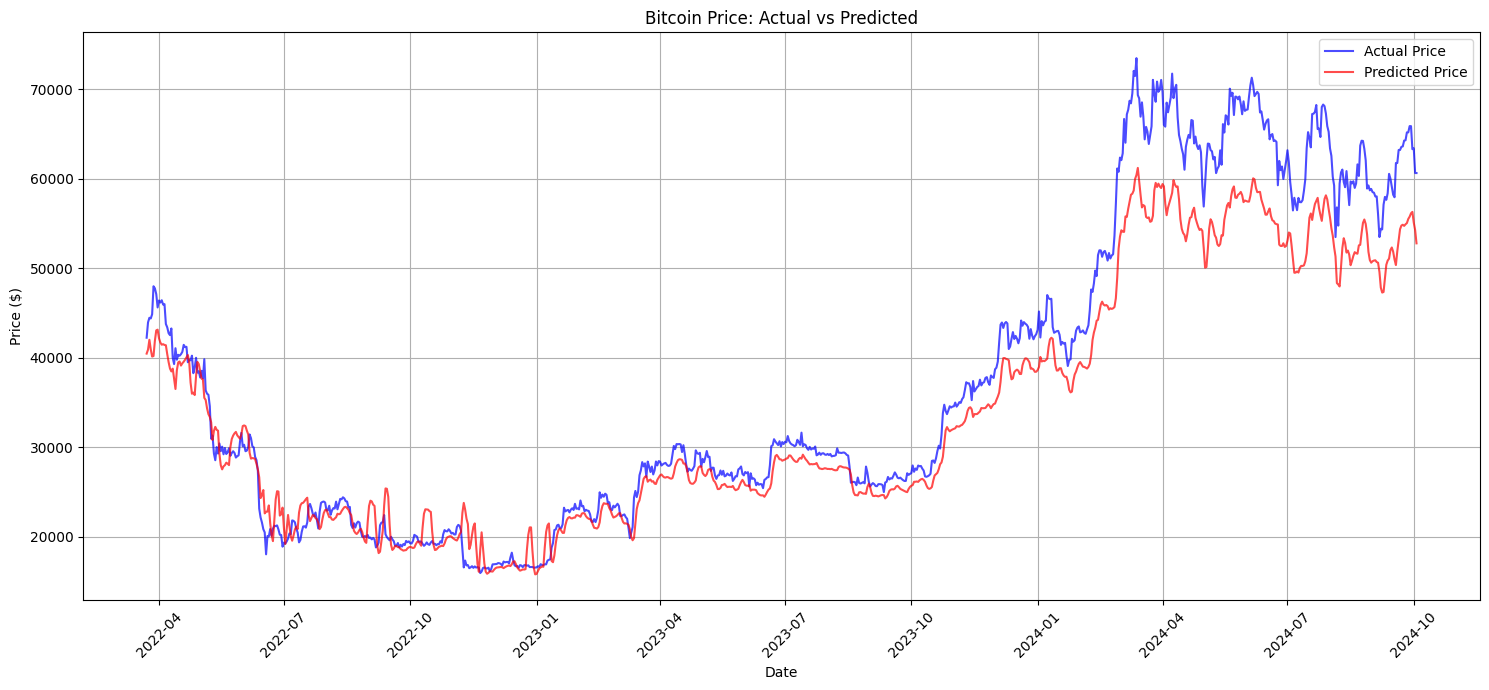

In [11]:
# Plotting
plt.figure(figsize=(15, 7))
plt.plot(dates, y_test_original, label='Actual Price', color='blue', alpha=0.7)
plt.plot(dates, y_pred, label='Predicted Price', color='red', alpha=0.7)
plt.title('Bitcoin Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save results to dictionary
results = {
    'mae': mae,
    'mape': mape,
    'prediction_runtime': prediction_runtime,
    'dates': dates,
    'actual_prices': y_test_original.flatten(),
    'predicted_prices': y_pred.flatten()
}

In [13]:
# Save results
joblib.dump(results, '../models/evaluation_test_results.pkl')

['../models/evaluation_test_results.pkl']